In [1]:
%%html
<style>
figure {
    display: flex;
    flex-direction: column;
    align-items: center;
}
figure img {
    max-width: 900px;
    width: 80%;
    margin-bottom: 2em;
}
figcaption {
    aria-hidden: true;
    max-width: 700px;
}
</style>

# Methods

The practical implemntation of what is described in this section is available as a Python package called Koala (Kitaev On Amorphous LAttices) @tomImperialCMTHKoalaFirst2022 most of the figures shown were generated with Koala.

## Voronisation

In order to study the properties of the amorphous Kitaev model we need a way to sample from the space of possible trivalent graphs. 

A very simple way to do this is to use a Voronoi partition of the torus [@mitchellAmorphousTopologicalInsulators2018; @marsalTopologicalWeaireThorpeModels2020; @florescu_designer_2009]. We start by sampling _seed points_ uniformly (or otherwise) on the torus. We then compute the partition of the torus into regions closest (with a Euclidean metric) to each seed point. The straight lines (if the torus is flattened out) at the borders of these regions become the edges of the new lattice and the points where they intersect beceme the vertices. 

The graph generated by a Voronoi partition of a two dimensional surface is always planar meaning that no edges cross eachother when the graph is embedded into the plane. It is also trivalent in the sense that every vertex is connected to exactly three edges __cite__.

Ideally we might instead sample uniformly from the space of possible trivalent graphs, and indeed there has been some work on how to do this using a Markov Chain Monte Carlo approach @alyamiUniformSamplingDirected2016, however it does not gurantee that the resulting graph is planar which we will need to ensure that the edges can be 3-coloured.

In practice, we then use a standard algorithm @barberQuickhullAlgorithmConvex1996 from scipy @virtanenSciPyFundamentalAlgorithms2020a which actually computes the Voronoi partition of the plane. In order to compute the Voronoi partition of the torus, I take the seed points and replicate them into a repeating grid, either 3x3 (or for very small numbers of seed points 5x5). I then identify edges in the output to construct a lattice on the torus.

<figure>
<img src="../figure_code/amk_chapter/lattice_construction_animated/lattice_construction_animated.gif" style="max-width:700px;">
<figcaption>
(Left) Lattice construction begins with the Voronoi partition of the plane with respect to a set of seed points (black points) sampled uniformly from $\mathbb{R}^2$. (Center) However we actually want the Voronoi partition of the torus so we tile the seed points into a three by three grid. The boundaries of each tile are shown in light grey. (Right) Finally we indentify edges correspond to each other across the boundaries to produce a graph on the torus. An edge colouring is shown here to help the reader identify corresponding edges.
</figcaption>
</figure>

## Graph Representation

There are three keys pieces of information that we use to represent amorphous lattices. 

Most of the graph connectivity is encoded by an ordered list of edges $(i,j)$. These are ordered so that we can represent both directed and undirected graphs which is useful for defining the sign of bond operators $u_{ij} = - u_{ji}$.

Information about the embedding of the lattice onto the torus is encoded into a point on the unit square associated with each vertex. The torus is unwrapped onto the square by defining an arbitary pair of cuts along the major and minor axes which for simplicity we take to be the lines $x = 0$ and $y = 0$. We can wrap the unit square back up into a torus by identifying the lines $x = 0$ with $x = 1$ and $y = 0$ with $y = 1$. 

Finally, we need a way to encode the topology of the graph. We need this because given simply an edge $(i, j)$ we do not know how the edge gets from vertex i to vertex j. It could do so by taking the shortest path but it could also 'go the long way around' by crossing one of the cuts. To encode this information we store an additional vector $\vec{r}$ associated with each edge. $r_i^x = 0$ means that edge i does not cross the x while $r_i^x = +1$ ($-1$) means it crossed the cut in a positive (negative) sense.

This description of the lattice has a very nice relationship to Bloch's theorem. When you apply Bloch's theorem to a periodic lattice you essentially wrap the unit cell onto a torus. Variations that happen at longer length scales than the size of the unit cell are captured by the crystal momentum which inserts a phase factor $e^{i \vec{q}\cdot\vec{r}}$ onto bonds that cross to adjacent unit cells. The vector $\vec{r}$ is exactly what we use to encode the topology of our lattices.

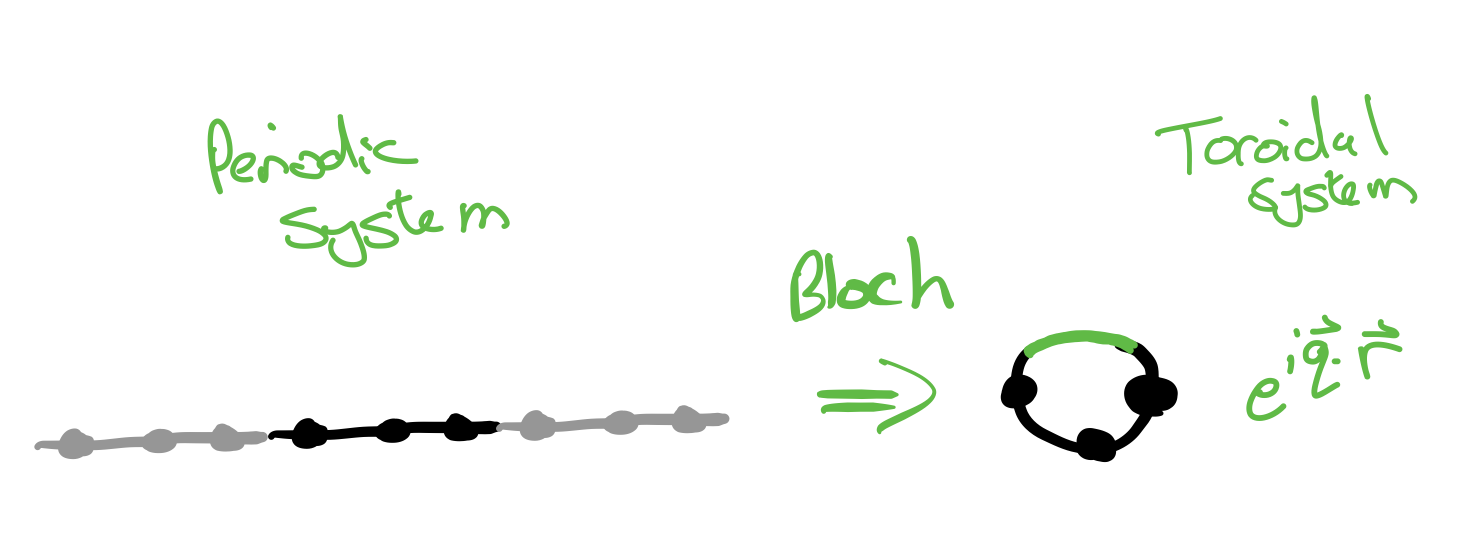

## Coloring the Bonds
The Kitaev model requires that each edge in the lattice be assigned a label $x$, $y$ or $z$ such that each vertex has exactly one edge of each type connected to it. Let $\Delta$ be the maximum degree of a graph which in our case is 3. If $\Delta > 3$ it is obviously not possible to 3 color the edges but the general theory of when this is and isn't possible for graphs with $\Delta \leq 3$ is more subtle. 

In the graph theory literature, graphs where all vertices have degree 3 are commonly called cubic graphs, there is no term for graphs with maximum degree 3. Planar graphs are those that can be embedded onto the plane without any edges crossing. Bridgeless graphs do not contain any edges that, when removed, would partition the graph into disconnected components. 

It's important to be clear that this problem is different from that considered by the famous 4 color theorem @appelEveryPlanarMap1989 . The 4 color thorem is concerned with assiging colours to the __vertices__ of a graph such that no vertices that share an edge are the same colour. Here we are concerned with an edge colouring.

The four color theorem applies to planar graphs, those that can be embedded onto the plane without any edges crossing. Here we are actually concerned with Toroidal graphs which can be embedded onto the torus without any edges crossing. In fact toroidal graphs require up to 7 colors @heawoodMapColouringTheorems . The complete graph $K_7$ is a good example of a toroidal graph that requires 7 colours. 

$\Delta + 1$ colours are enough to edge-colour any graph and there is an $\mathcal{O}(mn)$ algorithm to do it for a graph with $m$ edges and $n$ vertices @gEstimateChromaticClass1964. Restricting ourselves to graphs with $\Delta = 3$ like ours, those can be 4-edge-coloured in linear time @skulrattanakulchai4edgecoloringGraphsMaximum2002 . 

It's trickier if we want to 3-edge-colour them however. Cubic, planar bridgeless graphs can be 3-edge-coloured if and only if they can be 4-face-coloured @tait1880remarks . For which there is an $\mathcal{O}(n^2)$ algorithm robertson1996efficiently . However it is not clear whether this extends to cubic, __toroidal__ bridgeless graphs.

### Four-colourings and three-colourings

The proof of that  4-face-colourablity implies 3-edge-colourability can be sketched out quite easily:
1. Assume the faces of G can be 4-coloured with labels (0,1,2,3)
2. Label each edge of G according to $i + j \mathrm{mod} 3$ where i and j are the labels of the face adjacent to that edge. For each edge label there are two face label pairs that do not share any face labels. i,e the edge label $0$ can come about either from faces $0 + 3$ or $1 + 2$.

$$\begin{aligned}
0 + 3 \;\mathrm{or}\; 1 + 2 &= 0 \;\mathrm{mod}\; 3\\ 
0 + 1 \;\mathrm{or}\; 2 + 3 &= 1 \;\mathrm{mod}\; 3\\
0 + 2 \;\mathrm{or}\;1 + 3 &= 2 \;\mathrm{mod}\; 3\\
\end{aligned}
$$

3. In a cubic planar G, a vertex v in G is always part of 3 faces and the colors of those faces determines the colors of the edges that connect to v. The three faces must take three distinct colors from (0,1,2,3).
4. From there's easy to convince yourself that those three distinct face colours can never produce repeated edge colours according to the $i+j \;\mathrm{mod}\; 3$ rule.

This implies that all cubic planar graphs are 3-edge-colourable. It does not apply to toroidcal graphs, however I have not yet generated a voronoi lattices on the torus that is not 3-edge-colourable. This suggests that perhaps voronoi lattices have additional structure that makes them 3-edge-colourable. Intuitively, the kinds of toroidal graphs that cannot be 3-edge-coloured look as if they could never be generated by a voronoi partition with more than a few seed points.

### Finding Lattice colourings in practice (unfinished)
Some things are harder in theory than in practice. 3-edge-colouring cubic toroidal graphs appears to be one of those things.

The approach I take is relatively standard in the computer science community for solving NP problems computationally. I don't believe this problem to be in NP but I tried it anyway.

The trick is to map the problem on into a Boolean Satisfiability 'SAT' problem [@Karp1972], use an off the shelf solver, `MiniSAT` [@imms-sat18], and finally to map the problem back to the original domain. While SAT solvers are very general, they are also highly optimised and they do seem to yield good results for this problem.

SAT solvers encode problems as constraints on some number of boolean variables $x_i \in {0,1}$. The constraints must Conjunctive Normal Form (CNF). CNF means the constraints are encoded as a set of clauses of the form
$$x_1 \;\textrm{or}\; \bar{x}_3 \;\textrm{or}\; x_5$$
that containt logical ORs of some subset of the variables where any of the variables may also be logical NOT'd which I represent by over bars here.

A solution of the problem is one that makes all the clauses simultaneously true.

I encode the edge colouring problem as a set of statements about a set of boolean variables $x_i \in {0,1}$. For $B$ bonds we take the $3B$ variables $x_{i\alpha}$ where $x_{i\alpha} = 1$ indicates that edge $i$ has colour $\alpha$. 



For edge colouring graphs we need two kinds of constraints: 
1. Each edge is exactly one colour.
2. No neighbouring edges are the same color. 

The first constraint is a kind of artifact of doing this mapping over to boolean variables, the solver doesn't know anything about the structure of the problem unless it is encoded into the variables.

The second constraint encodes the structure of the graph itself and can be constructed easily from the adjacency matrix. 

I'll fill in the encoding later but the gist is that we can give this to a solver and get back: whether the problem is solveable, a solution or all the possible solutions. Finding a solution is relatively fast, while finding all the solutions is slower since there appear to be exponentially many of them. Fig \ref{fig:multiple_colourings} shows some examples. 

<figure>
<img src="../figure_code/amk_chapter/multiple_colourings/multiple_colourings.svg" style="max-width:700px;">
<figcaption>
Three different valid 3-edge-colourings of amorphous lattices. Colors that differ from the leftmost panel are highlighted.
</figcaption>
</figure>

### Does it matter which colouring we choose? 

In the isotropic case $J^\alpha = 1$ it is easy to show that it can't possibly make a difference. As the choice of how we define the four Majoranas at a site is arbitrary we can define a local operator that tranforms the colouring of any particular site to another permutation. The operators commute with the Hamiltonian and by composing such operators we can tranform the Hamiltonian generated by one colouring into that generated by another.

We can't do this in the anisotropic case however, and it remains an open question whether particular physical properties could arise by engineering the colouring in this phase.  

## Mapping between flux sectors and bond sectors
Constructing the Majorana representation of the model requires the particular bond configuration $u_{jk} = \pm 1$. However the large number of gauge symmetries of the bond sector make it unwieldly to work with. We therefore need a way to quickly map between bond sectors and flux sectors. 

Going from the bond sector to flux sector is easy since we can compute it directly by taking the product of $i u_{jk}$ around each plaquette
$$ \phi_i = \prod_{(j,k) \; \in \; \partial \phi_i} i u_{jk}$$

Going from flux sector to bond sector requires more thought however. The algorithm I use is this:

1. Fix the gauge by choosing some arbitrary $u_{jk}$ configuration. In practice I use $u_{jk} = +1$. This chooses an arbitrary one of the 4 topological sectors.

2. Compute the current flux configuration and how it differs from the target one. Let's call an plaquette that differs from the target a defect.

3. Find any adjacent pairs of defects and flip the $u_jk$ between them. This leaves a set of isolated defects. 

4. Pair the defects up using a greedy algorithm.

5. Compute paths along the dual lattice between each pair of plaquettes. Flipping the corresponding set of $u_{jk}$ transports one flux to the other and anhilates them.

<figure>
<img src="../figure_code/amk_chapter/flux_finding/flux_finding.svg" style="max-width:700px;">
<figcaption>
(Left) The ground state flux sector and bond sector for an amorphous lattice. Bond arrows indicate the direction in which $u_{jk} = +1$. Plaquettes are coloured blue when $\hat{\phi}_i = -1$ ($-i$) for even (odd) plaquettes and orange when $\hat{\phi}_i = +1$ ($+i$) for even/odd plaquettes. (Centre) In order to transform this to the target flux sector (all $+1$/$+i$) we first flip any $u_{jk}$ that are between two fluxes. This leaves a set of isolated fluxes that need to be anhilated. These are then paired up as indicated by the black lines. (Right) A* search is used to find paths (coloured plaquettes) on the dual lattice between each pair of fluxes and the coresponding $u_{jk}$ (shown in black) are flipped. One flux has will remain because the starting and target flux sectors differed by an odd number of fluxes.
</figcaption>
</figure>

## Chern Markers

We know that the standard Kitaev model supports both Abelian and non-Abelian phases, so how can we assess whether this is also the case for the amorphous Kitaev model? 

We have already discussed the fact that topology and anyonic statistics are intimately linked and this will help here. The Chern number is a quantity that measured the topological characteristics of a material. 

The original definition of the Chern number relies on the model having translation symmetry. This lead to the development of _local markers_, these are operators defined locally that generalise the notion of the chern number to a local observable over some region smaller than the entire system. 

